# Sorghum Shape and Morphology Analysis

This is a full workflow that shows methods for analyzing shape, color, and morphological features of plants imaged from a side-view. Similar methods should work for other tyles of plants that are imaged in a similar way.

In [1]:
# Set the notebook display method
# If widget is not working, then change to inline
%matplotlib inline

# Section 1: Importing libraries 

In [2]:
# Import libraries
from plantcv import plantcv as pcv 
from plantcv.parallel import WorkflowInputs

# Print out the version of PlantCV being used by the Jupyter kernel
pcv.__version__

'4.6'

## Input/Output variables

The options class mimics the workflow command-line argument parser that is used for workflow parallelization. Using it while developing a workflow in Jupyter makes it easier to convert the workflow to a script later.

In [3]:
# Input/output options
args = WorkflowInputs(
    images=["img/side_view_sorghum.png"],    
    names="image1",
    result="side_view_morphology_analysis.json",
    outdir=".",
    writeimg=True,
    debug="plot"
    )

In [4]:
# Set debug to the global parameter
pcv.params.debug = args.debug

# Set plotting size (default = 100)
pcv.params.dpi = 100

# Increase text size and thickness to make labels clearer
# (size may need to be altered based on original image size)
pcv.params.text_size = 20
pcv.params.text_thickness = 20
pcv.params.line_thickness = 10

## Read the input image

### Reading images into your environment using *pcv.readimage()*
Inputs:
   * filename = Image file to be read in
   * mode     = How the image will be read into the notebook; either 'native' (default), 'rgb', 'gray', 'csv', or 'envi'

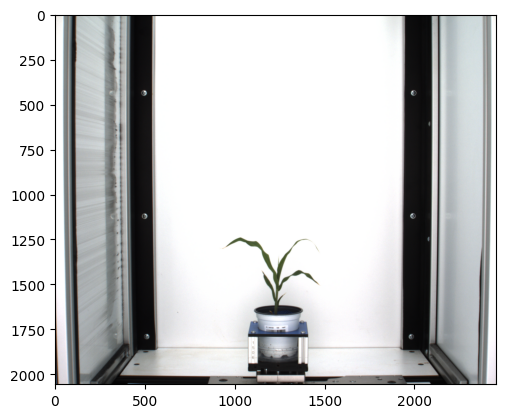

In [5]:
img, path, filename = pcv.readimage(filename=args.image1)

# Section 2: Isolating plant, making binary mask, getting object(s)
* Requires successful import of image
* See Tools for Thresholding Plant Material for a full list of functions  that can be used to create a binary mask

## Visualize colorspaces

The visualization tool converts the color image into HSV and LAB colorspaces and displays the grayscale channels in a matrix so that they can be visualized simultaneously. The idea is to select a channel that maximizes the difference between the plant and the background pixels.

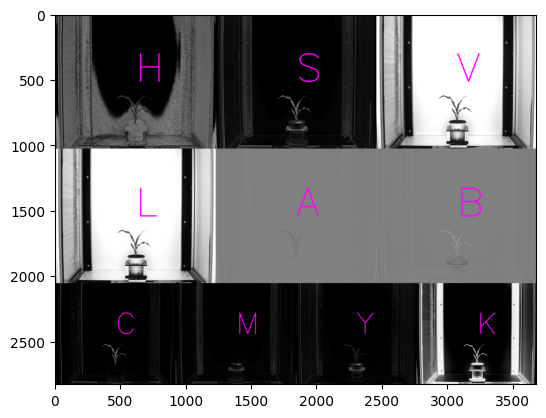

In [6]:
colorspaces = pcv.visualize.colorspaces(rgb_img=img, original_img=False)

## Convert the color image to grayscale

Converts the input color image into the LAB colorspace and returns the B (blue-yellow) channel as a grayscale image.

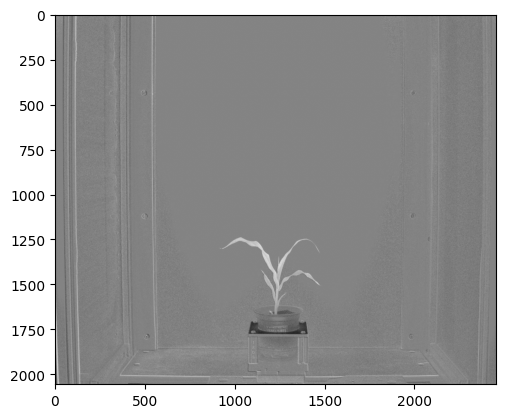

In [7]:
b = pcv.rgb2gray_lab(rgb_img=img, channel="b")

## Visualize the distribution of grayscale values

A histogram can be used to visualize the distribution of values in an image. The histogram can aid in the selection of a threshold value.

For this image, the large peak between 120-130 are from the darker background pixels. The smaller peaks that represent plant material cannot be distinguished because there are so few total plant pixels, but we can use the upper bound of the background peaks to estimate a good thresholding point, somewhere between 127-135.

In [8]:
hist = pcv.visualize.histogram(img=b)

alt.Chart(...)

## Threshold the grayscale image

Use a threshold function (binary in this case) to segment the grayscale image into plant (white) and background (black) pixels. Using the histogram above, a threshold point between 120-125 will segment the plant and background peaks. Because the plant has darker pixels in this image, use object_type="dark" to do a traditional threshold.

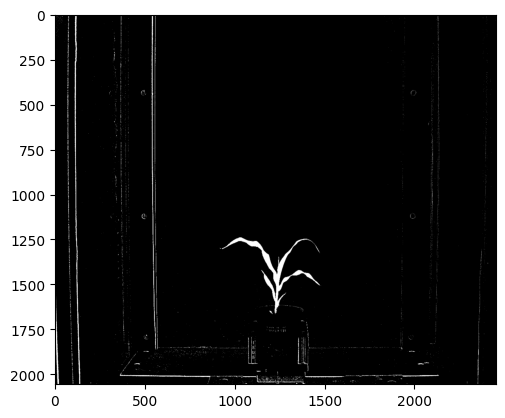

In [9]:
b_thresh = pcv.threshold.binary(gray_img=b, threshold=134, object_type='light')

## Identify objects within a region of interest (ROI)
To eventually combine all of the objects into a singular object that identifies the plant, we need to identify a region of interest (ROI) which will either fully encapsulate or overlap with plant material. This way, if objects are identified due to "salt" noise or other background elements, they will be filtered out. In this case, a rectangular ROI that partially overlaps with the plant object can be used to filter out some of the excess noise around the plant.

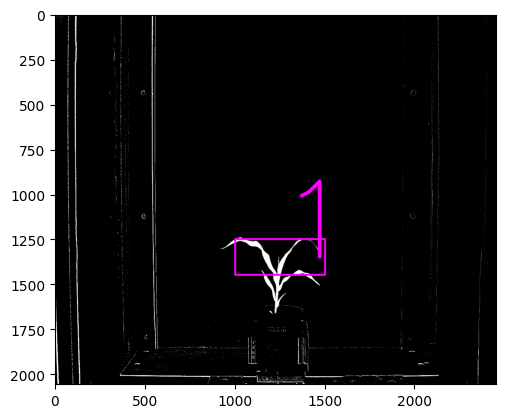

In [10]:
roi1 = pcv.roi.rectangle(img=b_thresh, x=1000, y=1250, h=200, w=500)

## Filter out objects that don't overlap with the ROI
Any objects that do not overlap with the ROI will be filtered out, leaving only objects that identify plant material.

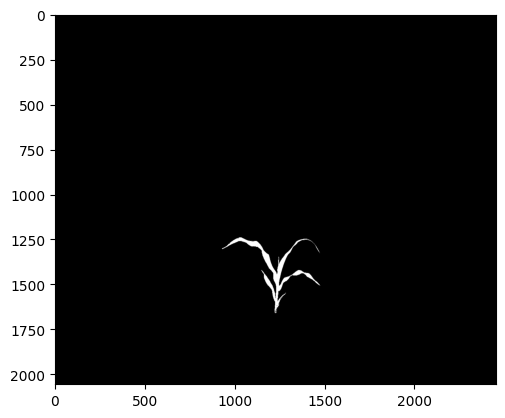

In [11]:
kept_mask = pcv.roi.filter(mask=b_thresh, roi=roi1, roi_type='partial')

## Crop the mask

This is entirely optional, but it can help to look closer at the mask to ensure there is no "salt" noise or any other issues with the binary mask that aren't clear. To visualize the cropped mask, use plot_image.

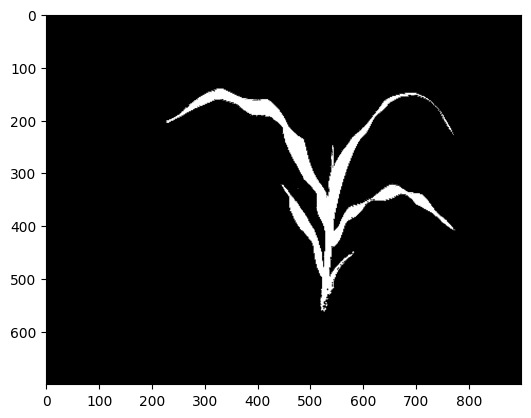

In [12]:
# Chose to directly crop the images using base Python, but could also use pcv.crop() 
cropped_mask = kept_mask[1100:1800, 700:1600]
cropped_img = img[1100:1800, 700:1600]
pcv.plot_image(cropped_mask)

## Dilate white pixels to preserve plant material

Especially in images with thin leaves, there is a greater risk that when removing 'salt' background noise, some of the plant pixels will be degraded as well. This can be avoided by dilating the image, which increases white pixel area i times. 

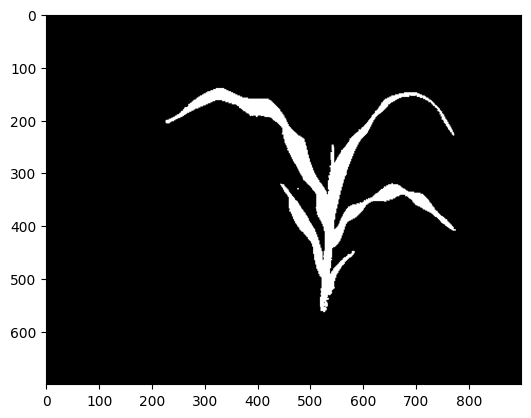

In [13]:
mask_dilated = pcv.dilate(gray_img=cropped_mask, ksize=3, i=1)


## Remove small background noise¶
Thresholding mostly labeled plant pixels white but also labeled small regions of the background white. The fill function removes "salt" noise from the background by filtering white regions by size. After dilating, we can see a few specks of noise that would otherwise interfere with the morphology analysis functions.

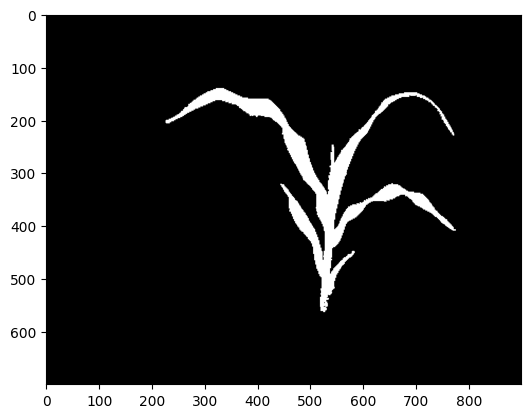

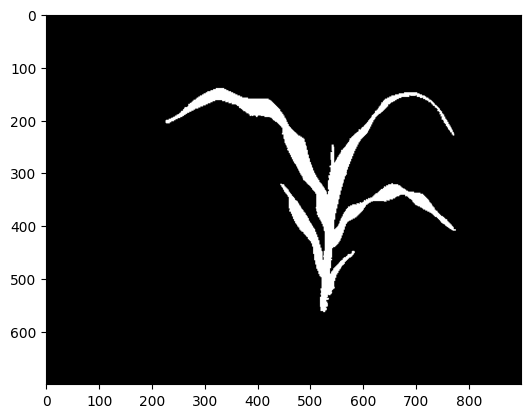

In [14]:
mask_fill = pcv.fill(bin_img=mask_dilated, size=30)
mask_fill = pcv.fill_holes(bin_img=mask_fill)

# Section 3: Morphology analysis

* Requires plant image and completed binary mask

## Skeletonize the mask

Convierte la máscara en un esqueleto de 1 píxel de ancho, que puede utilizarse para análisis morfológico.

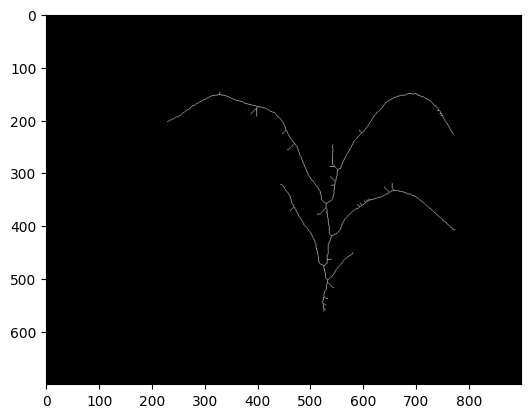

In [15]:
skeleton = pcv.morphology.skeletonize(mask=mask_fill)

# Prune the skeleton

Generalmente, las imágenes esqueletizadas tendrán ramificaciones que representan el ancho del material vegetal, las cuales deberán ser eliminadas.

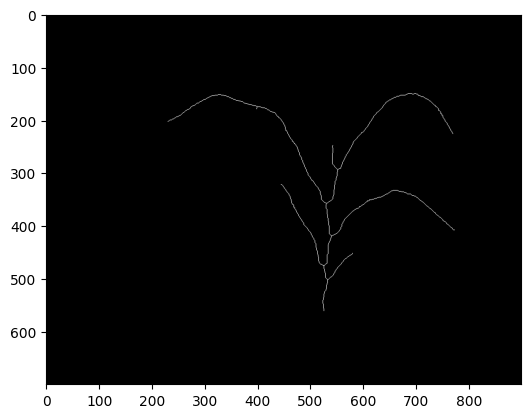

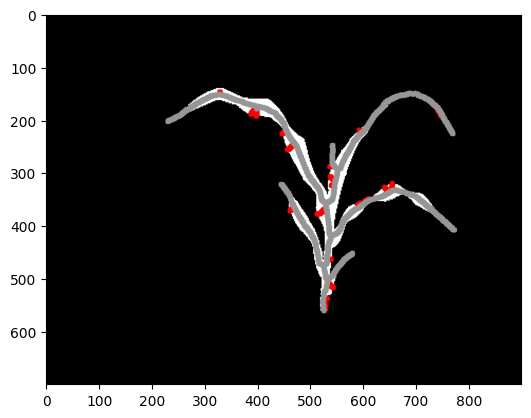

In [16]:
pruned_skel, seg_img, edge_objects = pcv.morphology.prune(skel_img=skeleton, size=50, mask=mask_fill)

La hoja superior izquierda todavía tiene una ramificación, por lo que se está dividiendo en dos segmentos. Vamos a podar nuevamente para eliminar esa ramificación persistente.


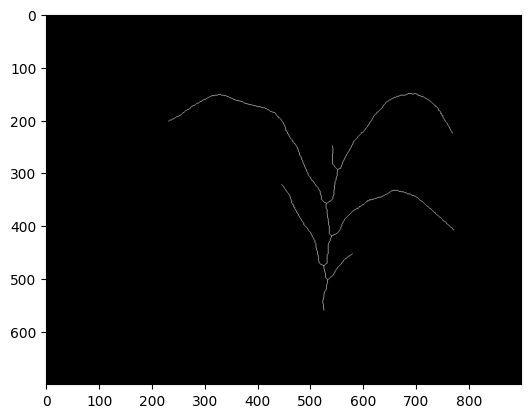

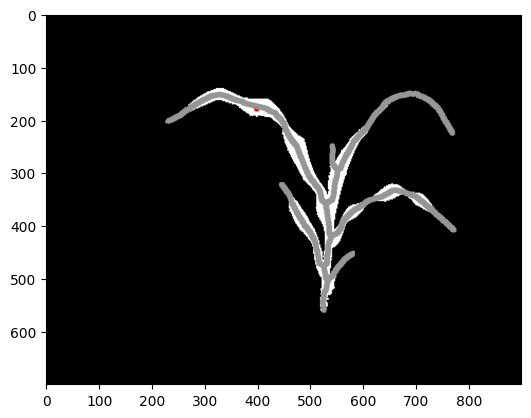

In [17]:
pruned_skel, seg_img, edge_objects = pcv.morphology.prune(skel_img=pruned_skel, size=50, mask=mask_fill)

## Sort segments into stem and leaves

Diferencia entre el segmento primario (tallo) y los segmentos secundarios (hojas). Los pasos posteriores pueden realizarse en una sola clase de objetos a la vez o en todos los objetos.

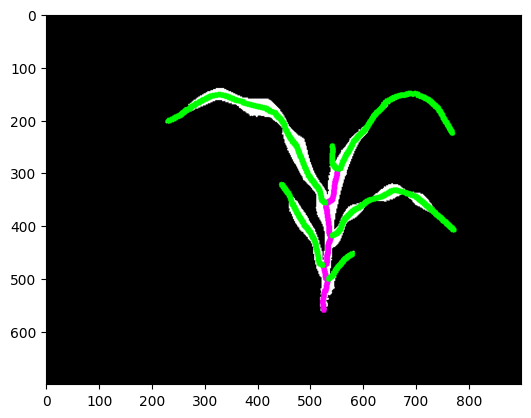

In [18]:
leaf_obj, stem_obj= pcv.morphology.segment_sort(skel_img=pruned_skel, objects=edge_objects, mask=mask_fill)


## Fill in segments

Rellena los diferentes segmentos (ramas/hojas) de la planta en la máscara binaria y guarda los datos de área de cada segmento.

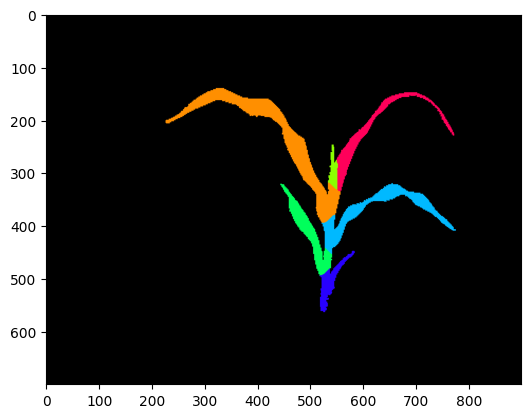

In [19]:
filled_img = pcv.morphology.fill_segments(mask=mask_fill, objects=leaf_obj, label="default")

## Identify branch points

Encuentra los puntos de ramificación o unión a partir de una imagen de esqueleto.

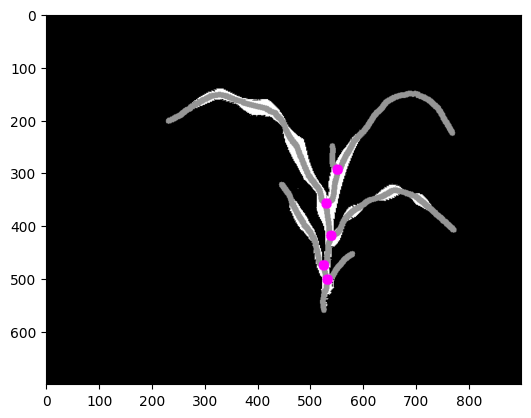

In [20]:
branch_pts_mask = pcv.morphology.find_branch_pts(skel_img=pruned_skel, mask=cropped_mask, label="default")

## Identify tip points

Encuentra los puntos terminales de las ramas.

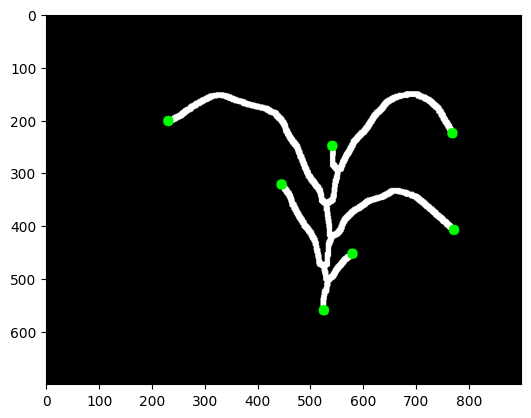

In [21]:
tip_pts_mask = pcv.morphology.find_tips(skel_img=pruned_skel, mask=None, label="default")

In [22]:
# Downsize parameters to make annotations more readable 
pcv.params.text_size = 2
pcv.params.text_thickness = 3
pcv.params.line_thickness = 10

## Identify segments

Identifica y etiqueta los segmentos únicos a partir de la imagen esqueletizada.

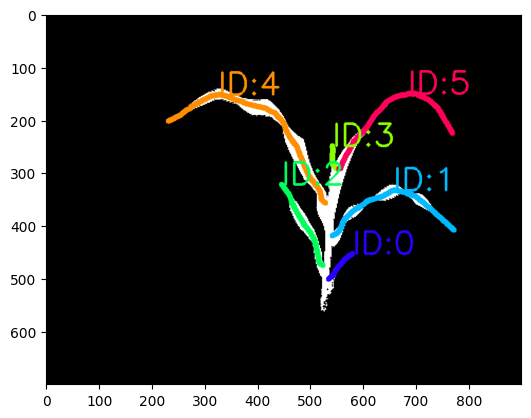

In [23]:
segmented_img, labeled_img = pcv.morphology.segment_id(skel_img=pruned_skel,
                                                       objects=leaf_obj,
                                                       mask=cropped_mask)

# Measure length of segments

Mide y grafica la longitud del trayecto de cada segmento.

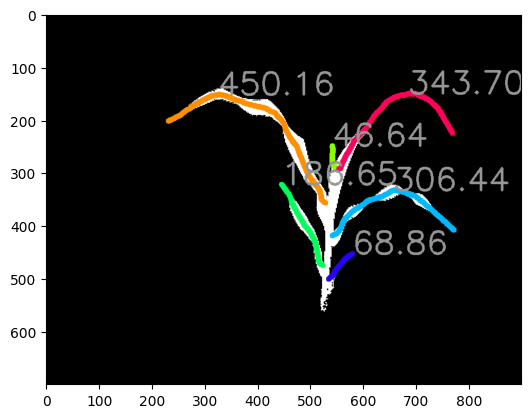

In [24]:
labeled_img  = pcv.morphology.segment_path_length(segmented_img=segmented_img, 
                                                  objects=leaf_obj, label="default")



## Measure euclidean distance of segments

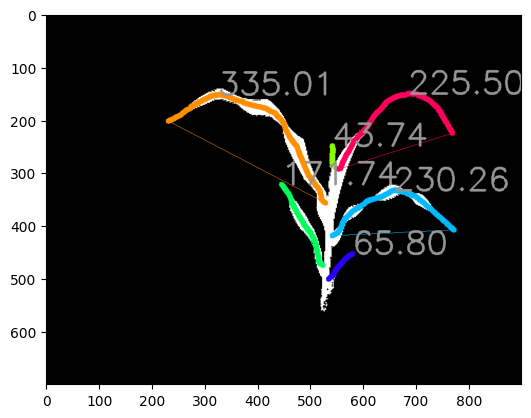

In [25]:
labeled_img = pcv.morphology.segment_euclidean_length(segmented_img=segmented_img, 
                                                      objects=leaf_obj, label="default")

## Measure curvature of segments

Calcula la curvatura de los segmentos tomando la razón entre la distancia geodésica (`plantcv.morphology.segment_path_length`) y la distancia euclidiana (`plantcv.morphology.segment_euclidean_length`). Es una medida de la tortuosidad en dos dimensiones. Los valores cercanos a 1 indican que un segmento es una línea recta, mientras que los valores mayores indican que el segmento tiene más curvatura. Los usuarios pueden pasar únicamente objetos de hojas (devueltos por `plantcv.morphology.segment_sort`) para calcular exclusivamente la curvatura de las hojas.

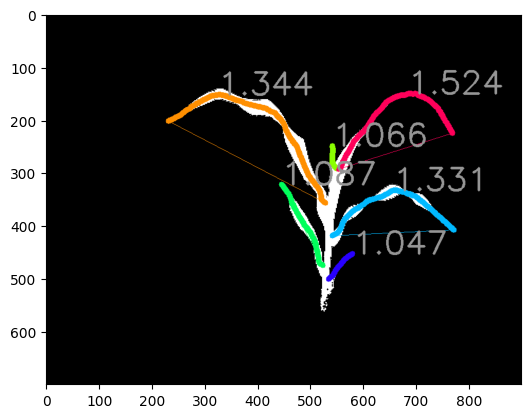

In [26]:
labeled_img = pcv.morphology.segment_curvature(segmented_img=segmented_img, 
                                               objects=leaf_obj, label="default")




## Measure segment angle

Calcula el ángulo del segmento utilizando una línea de regresión lineal ajustada a cada segmento y determinando el ángulo en grados para cada uno.

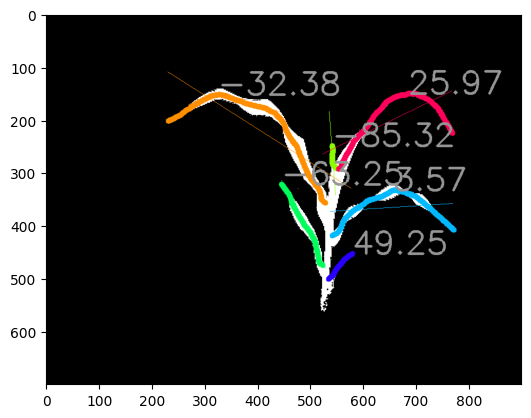

In [27]:
labeled_img = pcv.morphology.segment_angle(segmented_img=segmented_img, 
                                           objects=leaf_obj, label="default")

## Measure tangent angle of segments

Find tangent angles of skeleton segments and calculate angle between the two angles for each segment.

Encuentra los ángulos "tangentes" en grados de los segmentos del esqueleto. Utiliza píxeles de tamaño en ambos extremos de cada segmento para ajustar una línea de regresión lineal y calcula el ángulo entre las dos líneas dibujadas por segmento. Los usuarios pueden pasar únicamente objetos de hojas (devueltos por `plantcv.morphology.segment_sort`) para calcular exclusivamente los ángulos de las hojas.

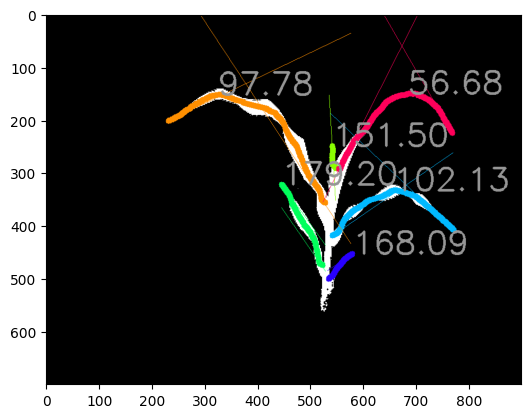

In [28]:
labeled_img = pcv.morphology.segment_tangent_angle(segmented_img=segmented_img,
                                                    objects=leaf_obj, size=15, label="default")

## Measure leaf insertion angle

Calcula el ángulo de inserción de la hoja en grados en comparación con el ángulo del tallo.

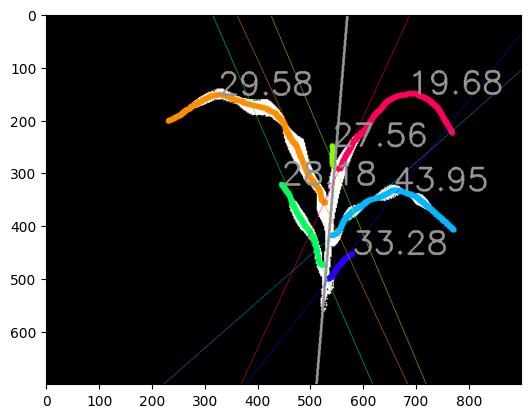

In [29]:
labeled_img = pcv.morphology.segment_insertion_angle(skel_img=pruned_skel,
                                                     segmented_img=segmented_img, 
                                                     leaf_objects=leaf_obj, 
                                                     stem_objects=stem_obj,
                                                     size=20, label="default")

## Analyze plant shape

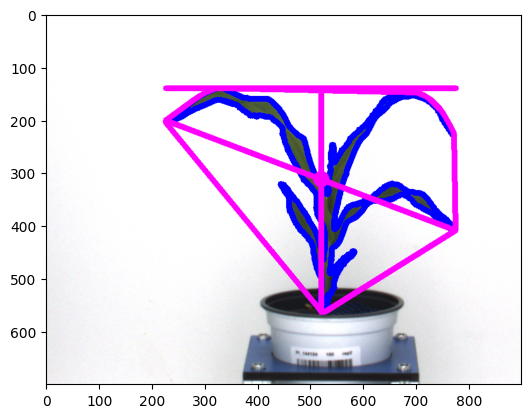

In [30]:
shape_img = pcv.analyze.size(img=cropped_img, labeled_mask=mask_fill, label="default")

# Save results

The save results function will take the measurements stored when running any PlantCV analysis functions, format, 
and print an output text file for data analysis. The Outputs class in this example will store: 'segment_area', 'tips', 'branch_pts', 'segment_angle', 'segment_curvature', 'segment_eu_length', 'segment_insertion_angle', 'segment_path_length', and 'segment_tangent_angle' from the morphology functions.

Here, results are saved to a CSV file for easy viewing, but when running workflows in parallel, save results as "json"

In [31]:
# Inputs:
#   filename  = filename for saving results
#   outformat = output file format: "json" (default) hierarchical format or "csv" tabular format
pcv.outputs.save_results(filename=args.result, outformat="json")

print(pcv.outputs.observations)

{'default': {'branch_pts': {'trait': 'list of branch-point coordinates identified from a skeleton', 'method': 'plantcv.plantcv.morphology.find_branch_pts', 'scale': 'pixels', 'datatype': "<class 'list'>", 'value': [(532, 502), (525, 475), (539, 419), (530, 358), (551, 294)], 'label': [0, 1, 2, 3, 4]}, 'tips': {'trait': 'list of tip coordinates identified from a skeleton', 'method': 'plantcv.plantcv.morphology.find_tips', 'scale': 'pixels', 'datatype': "<class 'list'>", 'value': [(563, 276), (758, 206)], 'label': [0, 1]}, 'segment_area': {'trait': 'segment area', 'method': 'plantcv.plantcv.morphology.fill_segments', 'scale': 'pixels', 'datatype': "<class 'list'>", 'value': [1940, 5822, 3696, 897, 11201, 4082], 'label': [0, 1, 2, 3, 4, 5]}, 'segment_path_length': {'trait': 'segment path length', 'method': 'plantcv.plantcv.morphology.segment_path_length', 'scale': 'pixels', 'datatype': "<class 'list'>", 'value': [68.8614347577095, 306.43964272737503, 186.6518018245697, 46.64213538169861, 